In [1]:
import numpy as np 
import pandas as pd
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.layers import Dropout

2024-02-18 20:59:25.979259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 20:59:25.979393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 20:59:26.124247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Preprocessing**

In [2]:
text = open('/kaggle/input/wonderland.txt', 'r', encoding='utf-8').read()
text = text.lower()

In [3]:
# Getting the number of unique characters
unique_characters = set(text)

# Getting the total number of characters
n_chars = len(text)

# Getting the total number of unique characters
n_vocab = len(unique_characters)

print("Total Characters : ",n_chars) 
print("Total Vocab : ",n_vocab)

Total Characters :  163817
Total Vocab :  61


In [4]:
# Mapping characters to integers
char_to_index = {char: i for i, char in enumerate(set(text))}
index_to_char = {i: char for i, char in enumerate(set(text))}

In [5]:
# Setting the parameters
sequence_length = 40
num_neurons = 256
num_distinct_chars = len(char_to_index)

In [6]:
# Convert the text to a sequence of indices
text_as_indices = [char_to_index[char] for char in text]

In [7]:
# Generate input sequences and corresponding labels
X = []
y = []

for i in range(0, len(text_as_indices) - (sequence_length*2), 1):
    sequence_in = text_as_indices[i:i + sequence_length]
    sequence_out = text_as_indices[i + sequence_length:i + (sequence_length*2)]
    X.append(sequence_in)
    y.append(sequence_out)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X
X = np.reshape(X, (X.shape[0], sequence_length, 1))

# One hot encoding
y = tf.keras.utils.to_categorical(y)

print(X.shape)
print(y.shape)

(163737, 40, 1)
(163737, 40, 61)


In [8]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=1)

# **Creating the model**

In [9]:
# Create the model
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(num_neurons, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(num_distinct_chars, activation='softmax'))

# Set initial weights
initial_weights = 0.05
for layer in model.layers:
    for weight in layer.get_weights():
        weight[:] = initial_weights

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 40, 256)           0         
                                                                 
 dense (Dense)               (None, 40, 61)            15677     
                                                                 
Total params: 805181 (3.07 MB)
Trainable params: 805181 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/20
1216/1216 [==============================] - 468s 382ms/step - loss: 3.0665 - accuracy: 0.1703 - val_loss: 3.0563 - val_accuracy: 0.1698
Epoch 2/20
1216/1216 [==============================] - 463s 381ms/step - loss: 3.0499 - accuracy: 0.1708 - val_loss: 3.0406 - val_accuracy: 0.1698
Epoch 3/20
1216/1216 [==============================] - 462s 380ms/step - loss: 3.0071 - accuracy: 0.1723 - val_loss: 2.9378 - val_accuracy: 0.1780
Epoch 4/20
1216/1216 [==============================] - 463s 380ms/step - loss: 2.8813 - accuracy: 0.1897 - val_loss: 2.7315 - val_accuracy: 0.2238
Epoch 5/20
1216/1216 [==============================] - 467s 384ms/step - loss: 2.7282 - accuracy: 0.2249 - val_loss: 2.5423 - val_accuracy: 0.2742
Epoch 6/20
1216/1216 [==============================] - 465s 382ms/step - loss: 2.6084 - accuracy: 0.2553 - val_loss: 2.4002 - val_accuracy: 0.3135
Epoch 7/20
1216/1216 [==============================] - 464s 381ms/step - loss: 2.5229 - accuracy: 0.2772 - val_

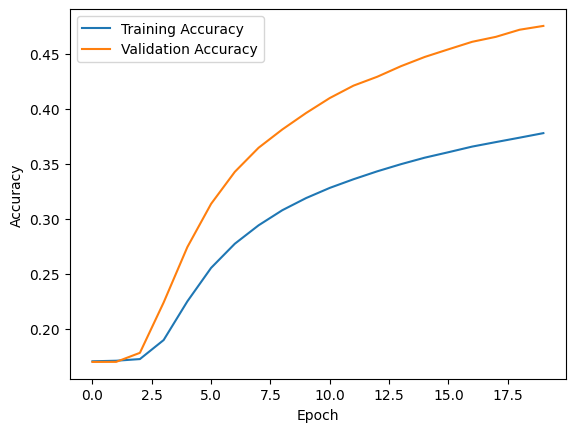

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy to epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

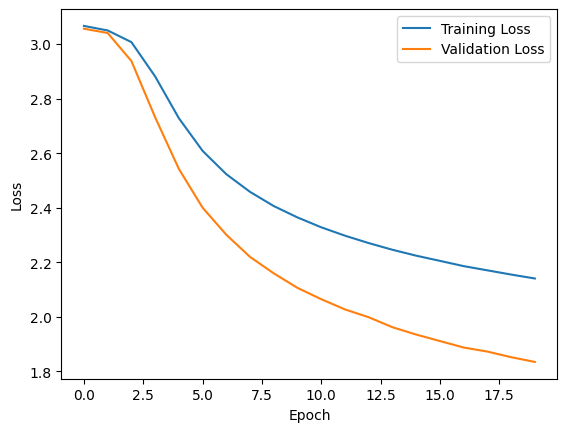

In [12]:
# Plot loss to epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [13]:
# Select a random starting point
start_index = np.random.randint(0, len(text) - sequence_length)

# Extract the character sequence
seed_text = text[start_index : start_index + sequence_length]

# Preprocess seed string
seed_sequence = [char_to_index[char] for char in seed_text]

# Reshape the seed_sequence to match the model's input shape
input_sequence = np.reshape(seed_sequence, (1, sequence_length, 1))

# Predict the next characters
predicted_probs = model.predict(input_sequence)[0]

# Convert predicted probabilities to actual characters
predicted_characters = [index_to_char[np.argmax(prob)] for prob in predicted_probs]

print(predicted_characters)

# Print the original input sequence
print("Input Sequence:", ''.join([char for char in seed_text]))

# Print the predicted characters
print("Predicted Characters:", ''.join(predicted_characters))

1/1 [==============================] - 1s 848ms/step
[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'l', 'o', 'r', ' ', ' ', 'c', 'o', 'r', 'e', ' ', ' ', 'h', 'a', 'r', ' ', 'm', 'o', 'u', 'b', 'e', 'r', 't', ' ', 'f', 'o', 'o', 't', 'm', 'a']
Input Sequence: otman in livery came running out of the

Predicted Characters:            lor  core  har moubert footma


# **Model 2**

In [14]:
# Create the model
model2 = Sequential()
model2.add(LSTM(num_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(num_neurons, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(num_neurons, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(Dense(num_distinct_chars, activation='softmax'))

# Set initial weights
initial_weights = 0.05
for layer in model2.layers:
    for weight in layer.get_weights():
        weight[:] = initial_weights

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 256)           264192    
                                                                 
 dropout_2 (Dropout)         (None, 40, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 40, 256)           525312    
                                                                 
 dropout_3 (Dropout)         (None, 40, 256)           0         
                                                                 
 lstm_4 (LSTM)               (None, 40, 256)           525312    
                                                                 
 dropout_4 (Dropout)         (None, 40, 256)           0         
                                                                 
 dense_1 (Dense)             (None, 40, 61)           

In [15]:
# Train the model
history = model2.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/20
1216/1216 [==============================] - 769s 627ms/step - loss: 3.0668 - accuracy: 0.1704 - val_loss: 3.0572 - val_accuracy: 0.1698
Epoch 2/20
1216/1216 [==============================] - 765s 629ms/step - loss: 3.0537 - accuracy: 0.1708 - val_loss: 3.0537 - val_accuracy: 0.1697
Epoch 3/20
1216/1216 [==============================] - 762s 627ms/step - loss: 3.0403 - accuracy: 0.1710 - val_loss: 3.0122 - val_accuracy: 0.1712
Epoch 4/20
1216/1216 [==============================] - 758s 623ms/step - loss: 2.9539 - accuracy: 0.1808 - val_loss: 2.8163 - val_accuracy: 0.2085
Epoch 5/20
1216/1216 [==============================] - 765s 629ms/step - loss: 2.7903 - accuracy: 0.2153 - val_loss: 2.5921 - val_accuracy: 0.2673
Epoch 6/20
1216/1216 [==============================] - 771s 634ms/step - loss: 2.6438 - accuracy: 0.2511 - val_loss: 2.4083 - val_accuracy: 0.3159
Epoch 7/20
1216/1216 [==============================] - 773s 636ms/step - loss: 2.5325 - accuracy: 0.2790 - val_

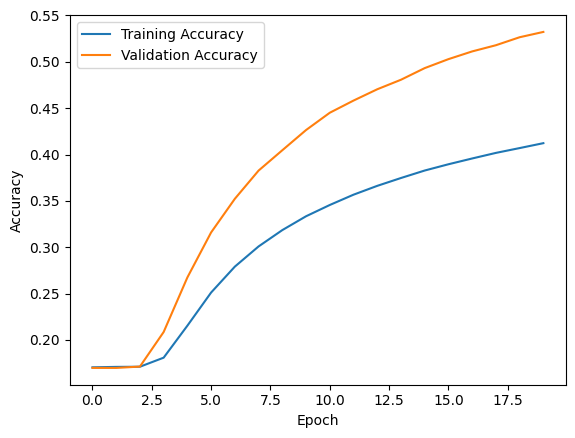

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy to epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

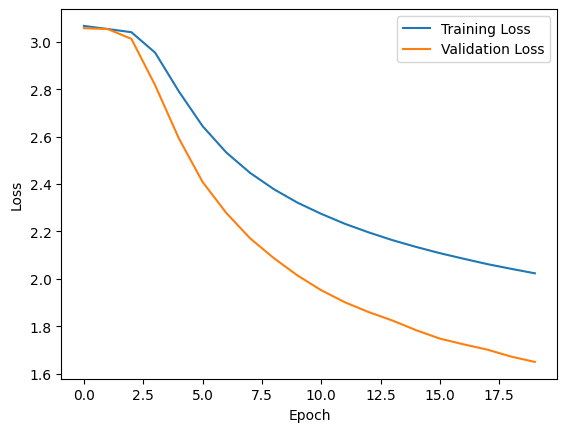

In [17]:
# Plot loss to epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [18]:
# Select a random starting point
start_index = np.random.randint(0, len(text) - sequence_length)

# Extract the character sequence
seed_text = text[start_index : start_index + sequence_length]

# Preprocess seed string
seed_sequence = [char_to_index[char] for char in seed_text]

# Reshape the seed_sequence to match the model's input shape
input_sequence = np.reshape(seed_sequence, (1, sequence_length, 1))

# Predict the next characters
predicted_probs = model2.predict(input_sequence)[0]

# Convert predicted probabilities to actual characters
predicted_characters = [index_to_char[np.argmax(prob)] for prob in predicted_probs]

print(predicted_characters)

# Print the original input sequence
print("Input Sequence:", ''.join([char for char in seed_text]))

# Print the predicted characters
print("Predicted Characters:", ''.join(predicted_characters))

1/1 [==============================] - 1s 1s/step
[' ', ' ', ' ', ' ', ' ', ' ', ' ', 'i', 'n', 'd', ' ', 't', 'o', 'r', 'm', 'o', 'u', 's', 'e', ' ', 't', 'r', 'o', 's', 's', 'e', 'd', ' ', 't', 'h', 'e', ' ', 'c', 'o', 'u', 'n', ',', ',', ' ', 's']
Input Sequence: r left off staring at the hatter, and,
j
Predicted Characters:        ind tormouse trossed the coun,, s
